# Reconocimiento de Texto con OpenCV OCR y Tesseract

## Instalar los paquetes necesarios

In [1]:
'''!pip install opencv-contrib-python
!pip install tesseract
!pip install pillow
!pip install pytesseract
!pip install imutils
'''

'!pip install opencv-contrib-python\n!pip install tesseract\n!pip install pillow\n!pip install pytesseract\n!pip install imutils\n'

## Entendiendo OpenCV OCR y Tesseract Text Recognition

![OpenCV OCR Pipeline](https://www.pyimagesearch.com/wp-content/uploads/2018/09/opencv_ocr_pipeline.png)

1.    Se pasa la imagen por OpenCV ETD para detectar la presencia de texto en la imagen. Este entrega las coordenadas (x,y) de los ROI's del texto (Region of Interest)
2.    Se extrae cada uno de los ROI y se pasan a través del algoritmo de Tesseract LSTM (Long Short-Time Memory), La cual es un tipo de RNN (Recurrent Neural Network)
3.    Entrega los resultados de OCR
4.    Graficar los resultados

## Importar librerías necesarias

In [2]:
from imutils.object_detection import non_max_suppression
import numpy as np
import pytesseract
import argparse
import cv2
import matplotlib.pyplot as plt
#%matplotlib inline
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\CAMILO\AppData\Local\Tesseract-OCR\tesseract.exe'

## Definimos la función `decode_predictions()`
Esta extrae y define los datos del resultado "scores" y "geometry"

In [3]:
def decode_predictions(scores, geometry):
	# grab the number of rows and columns from the scores volume, then
	# initialize our set of bounding box rectangles and corresponding
	# confidence scores
	(numRows, numCols) = scores.shape[2:4]
	rects = []
	confidences = []

	# loop over the number of rows
	for y in range(0, numRows):
		# extract the scores (probabilities), followed by the
		# geometrical data used to derive potential bounding box
		# coordinates that surround text
		scoresData = scores[0, 0, y]
		xData0 = geometry[0, 0, y]
		xData1 = geometry[0, 1, y]
		xData2 = geometry[0, 2, y]
		xData3 = geometry[0, 3, y]
		anglesData = geometry[0, 4, y]

		# loop over the number of columns
		for x in range(0, numCols):
			# if our score does not have sufficient probability,
			# ignore it
			if scoresData[x] < args["min_confidence"]:
				continue

			# compute the offset factor as our resulting feature
			# maps will be 4x smaller than the input image
			(offsetX, offsetY) = (x * 4.0, y * 4.0)

			# extract the rotation angle for the prediction and
			# then compute the sin and cosine
			angle = anglesData[x]
			cos = np.cos(angle)
			sin = np.sin(angle)

			# use the geometry volume to derive the width and height
			# of the bounding box
			h = xData0[x] + xData2[x]
			w = xData1[x] + xData3[x]

			# compute both the starting and ending (x, y)-coordinates
			# for the text prediction bounding box
			endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
			endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
			startX = int(endX - w)
			startY = int(endY - h)

			# add the bounding box coordinates and probability score
			# to our respective lists
			rects.append((startX, startY, endX, endY))
			confidences.append(scoresData[x])

	# return a tuple of the bounding boxes and associated confidences
	return (rects, confidences)

In [4]:
file_img = "../../Google Drive/opencv-text-recognition/opencv-text-recognition/images/example_02.jpg" #path a imagen de entrada
file_east = "../../Google Drive/opencv-text-recognition/opencv-text-recognition/frozen_east_text_detection.pb" #path al EAST text detector
c = 0.5 #probabilidad minima para determinar una region
w = 320 #multiplo de 32 para ancho de nuevo tamaño
e = 320 ##multiplo de 32 para altura de nuevo tamaño
p = 0.05 #cantidad de padding para añadir a cada frontera de ROI ("sobrante a los lados de la región")

## Se seleccionan los valores de preprocesamiento de la imagen

In [5]:
args = {"image" : file_img,
       "east" : file_east,
        "min_confidence" : c,
        "width" : w,
        "height" : e,
        "padding" : p
       }

## Se carga la imagen y se usa el algoritmo de CV para remodelar las dimensiones

In [6]:
# load the input image and grab the image dimensions
image = cv2.imread(args["image"])
orig = image.copy()
(origH, origW) = image.shape[:2]
# set the new width and height and then determine the ratio in change
# for both the width and height
(newW, newH) = (args["width"], args["height"])
rW = origW / float(newW)
rH = origH / float(newH)
# resize the image and grab the new image dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

## Se definen dos capas de procesamiento del algoritmo interno de OpenCV
* Se carga el modelo pre-entrenado de NN de EAST

In [7]:
# define the two output layer names for the EAST detector model that
# we are interested in -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]
# load the pre-trained EAST text detector
print("[INFO] loading EAST text detector...")
net = cv2.dnn.readNet(args["east"])

[INFO] loading EAST text detector...


## Se hace la predicción de los datos de la imagen a analizar
* A partir del modelo pre-entrenado
* Los resultados salen en `scores` y `geometry`.
* Se decodifican los resultados con la función `decode_predictions`
* El resultado se procesa y se une en la variable `boxes`

In [8]:
# construct a blob from the image and then perform a forward pass of
# the model to obtain the two output layer sets
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
	(123.68, 116.78, 103.94), swapRB=True, crop=False)
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
# decode the predictions, then  apply non-maxima suppression to
# suppress weak, overlapping bounding boxes
(rects, confidences) = decode_predictions(scores, geometry)
boxes = non_max_suppression(np.array(rects), probs=confidences)

## Se generan las ROI's para cada elemento hallado

In [9]:
# initialize the list of results
results = []
# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
	# scale the bounding box coordinates based on the respective
	# ratios
	startX = int(startX * rW)
	startY = int(startY * rH)
	endX = int(endX * rW)
	endY = int(endY * rH)
	# in order to obtain a better OCR of the text we can potentially
	# apply a bit of padding surrounding the bounding box -- here we
	# are computing the deltas in both the x and y directions
	dX = int((endX - startX) * args["padding"])
	dY = int((endY - startY) * args["padding"])
	# apply padding to each side of the bounding box, respectively
	startX = max(0, startX - dX)
	startY = max(0, startY - dY)
	endX = min(origW, endX + (dX * 2))
	endY = min(origH, endY + (dY * 2))
	# extract the actual padded ROI
	roi = orig[startY:endY, startX:endX]

## Se configuran los parámetros de la función `Tesseract`

* El parámetro `-l` es el idioma (en este caso inglés)
* El parámetro `--oem` es el motor.
* El parámetro `--psm` es el modo de segmentación del texto
```
$ tesseract --help-oem
OCR Engine modes:
  0    Legacy engine only.
  1    Neural nets LSTM engine only.
  2    Legacy + LSTM engines.
  3    Default, based on what is available.
```

```
OpenCV OCR and text recognition with Tesseract
$ tesseract --help-psm
Page segmentation modes:
  0    Orientation and script detection (OSD) only.
  1    Automatic page segmentation with OSD.
  2    Automatic page segmentation, but no OSD, or OCR.
  3    Fully automatic page segmentation, but no OSD. (Default)
  4    Assume a single column of text of variable sizes.
  5    Assume a single uniform block of vertically aligned text.
  6    Assume a single uniform block of text.
  7    Treat the image as a single text line.
  8    Treat the image as a single word.
  9    Treat the image as a single word in a circle.
 10    Treat the image as a single character.
 11    Sparse text. Find as much text as possible in no particular order.
 12    Sparse text with OSD.
 13    Raw line. Treat the image as a single text line,
       bypassing hacks that are Tesseract-specific.
```





In [10]:
# in order to apply Tesseract v4 to OCR text we must supply
config = ("-l eng --oem 1 --psm 3")
text = pytesseract.image_to_string(roi, config=config)
    # add the bounding box coordinates and OCR'd text to the list
    # of results
results.append(((startX, startY, endX, endY), text))
print(text)

® MIDDLEBOROUGCH £


## Graficar los resultados
Para cada ROI:
* Se hace un cuadro para el texto hallado
* Se escribe el texto encontrado

OCR TEXT
® MIDDLEBOROUGCH £



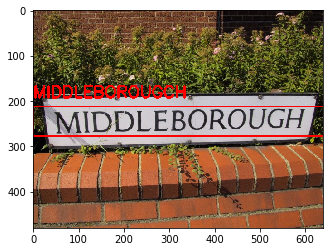

In [11]:
# sort the results bounding box coordinates from top to bottom
results = sorted(results, key=lambda r:r[0][1])
# loop over the results
for ((startX, startY, endX, endY), text) in results:
    # display the text OCR'd by Tesseract
    print("OCR TEXT")
    print("========")
    print("{}\n".format(text))
    # strip out non-ASCII text so we can draw the text on the image
    # using OpenCV, then draw the text and a bounding box surrounding
    # the text region of the input image
    text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
    output = orig.copy()
    cv2.rectangle(output, (startX, startY), (endX, endY),
                (0, 0, 255), 2)
    imagen = cv2.putText(output, text, (startX, startY - 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3)
    # show the output image

    #cv2.imshow("Text Detection", output)
    #cv2.waitKey(0)
    
    #Se pone así para graficar RGB
    plt.imshow(imagen[:,:,::-1])
    plt.show()
    

*Tomado de: 
https://www.pyimagesearch.com/2018/09/17/opencv-ocr-and-text-recognition-with-tesseract/*